# Metodi di sintesi della distribuzione a posteriori {#sec-post-inference-prediction}

**Prerequisiti**

**Concetti e Competenze Chiave**

**Preparazione del Notebook**

In [1]:
%run ../../config.py # Import the configuration settings
import itertools
import logging
import statistics as stat
from scipy import stats
import cmdstanpy
from cmdstanpy import CmdStanModel
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

## Introduzione {.unnumbered}

L'obiettivo di questo capitolo è quello di descrivere i metodi di sintesi della distribuzione a posteriori mediante l'utilizzo della tecnica MCMC.

## Sintesi della Distribuzione a Posteriori

Il risultato di un'analisi bayesiana è una distribuzione a posteriori, contenente tutte le informazioni sui parametri dati un modello e un insieme di dati. Pertanto, riassumere la distribuzione a posteriori significa sintetizzare le conseguenze logiche del modello e dei dati analizzati. È prassi comune riportare, per ciascun parametro, una misura di posizione centrale (come la media, la moda o la mediana) per fornire un'idea della localizzazione della distribuzione, accompagnata da una misura di dispersione, quale la deviazione standard, per quantificare l'incertezza delle stime. La deviazione standard è adeguata per distribuzioni simili alla normale, ma può risultare fuorviante per distribuzioni di altra natura, come quelle asimmetriche.

Per riassumere la dispersione di una distribuzione a posteriori, si utilizza spesso l'Intervallo di Densità Più Alta (HDI, Highest-Density Interval). L'HDI è l'intervallo più breve che contiene una data porzione della densità di probabilità. Ad esempio, se diciamo che l'HDI al 95% per un'analisi è [2, 5], intendiamo che, secondo i nostri dati e modello, il parametro in questione si trova tra 2 e 5 con una probabilità di 0.95. Non vi è nulla di particolare nella scelta del 95%, del 50% o di qualsiasi altro valore; siamo liberi di scegliere, ad esempio, l'intervallo HDI all'89% o al 94% secondo le nostre preferenze. Idealmente, le giustificazioni per queste scelte dovrebbero dipendere dal contesto e non essere automatiche, ma è accettabile stabilire un valore comune come il 95%. Per ricordarci della natura arbitraria di questa scelta, il valore predefinito in ArviZ è del 94%.

ArviZ è un pacchetto Python per l'analisi esplorativa di modelli bayesiani e offre numerose funzioni utili per riassumere la distribuzione a posteriori.

## Campionamento con Stan

A scopo illustrativo, utilizziamo ancora una volta i dati relativi agli artisti della Generazione X presenti al MOMA. I dati consistono in 14 casi di successo, ovvero artisti della Generazione X, su un totale di 100 opere selezionate casualmente dal MOMA. Come fatto in precedenza, impostiamo il parametro $\theta$, che rappresenta la probabilità di appartenere alla Generazione X o alle successive, seguendo una distribuzione Beta(4, 6).

Per iniziare, eseguiamo il processo di campionamento MCMC usando Stan.

In [2]:
stan_file = os.path.join(
    project_directory, 'stan', 'moma.stan')

with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower = 0> N;
  int<lower = 0, upper = N> y;
  int<lower = 0> alpha_prior;
  int<lower = 0> beta_prior;
}
parameters {
  real<lower=0, upper=1> theta;
}
model {
  theta ~ beta(alpha_prior, beta_prior);
  y ~ binomial(N, theta);
}
generated quantities {
  int<lower=0, upper=N> y_rep;
  y_rep = binomial_rng(N, theta);
}



Compiliamo il modello:

In [3]:
model = CmdStanModel(stan_file=stan_file)

Definiamo il dizionario con i dati:

In [4]:
N = 100
y = 14

data = {
    'N': N, 
    'y': y,
    "alpha_prior" : 4,
    "beta_prior" : 6
    }

print(data)

{'N': 100, 'y': 14, 'alpha_prior': 4, 'beta_prior': 6}


Eseguiamo il campionamento:

In [5]:
trace = model.sample(
    data=data,
    iter_warmup = 1000,
    iter_sampling = 4_000,
    chains = 4,
    seed = 123,
    show_progress = False, 
    show_console = False
)

## Analisi della distribuzione a posteriori

La distribuzione a posteriori rappresenta la nostra conoscenza aggiornata riguardo al valore del parametro $\theta$ dopo aver osservato i dati. Combina le nostre credenze a priori riguardo al parametro (la distribuzione a priori) con le nuove evidenze fornite dai dati osservati (la funzione di verosimiglianza) per ottenere una nuova distribuzione che riflette la nostra comprensione aggiornata del parametro, ovvero la distribuzione a posteriori.

La distribuzione a posteriori ci dice quanto sia probabile ogni possibile valore del parametro alla luce dei dati osservati. Un picco stretto indica che i dati sono molto informativi rispetto al parametro, portando a una maggiore certezza nella sua stima. Un picco largo, invece, indica maggiore incertezza.

La distribuzione a posteriori rappresenta un aggiornamento delle nostre credenze a priori in base ai dati osservati. 

In genere, il primo passo da fare dopo il campionamento è quello di verificare l'aspetto dei risultati. 

In [6]:
trace.draws().shape

(4000, 4, 9)

Le dimensioni `(4000, 4, 9)` restituite dall'istruzione `trace.draws().shape` in CmdStanPy si riferiscono alla struttura dei dati campionati ottenuti dall'esecuzione del modello Stan. Vediamo cosa rappresenta ciascuna dimensione:

1. **4000**: Questo rappresenta il numero di iterazioni di campionamento per catena. Qui, abbiamo specificato `iter_sampling = 4000`, quindi ci sono 4000 campioni per ciascuna catena.
   
2. **4**: Questo è il numero di catene. Abbiamo specificato `chains = 4`, quindi ci sono 4 catene di campionamento eseguite in parallelo.

3. **9**: Questo rappresenta il numero di parametri o quantità di interesse (inclusi parametri trasformati e quantità generate) che sono stati campionati. Include tutte le variabili definite nei blocchi `parameters`, `transformed parameters` e `generated quantities` del modello Stan.

Possiamo recuperare i nomi delle variabili dall'oggetto `trace` e il numero di campioni a posteriori per ciascuna variabile nel modo seguente:

In [7]:
vars = trace.stan_variables()
for (k,v) in vars.items():
    print(k, v.shape)

theta (16000,)
y_rep (16000,)


Recuperiamo i campioni posteriori per `theta`:

In [8]:
theta_samples = trace.stan_variable('theta')
theta_samples.shape

(16000,)

Generiamo un istogramma della distribuzione a posteriori di `theta`:

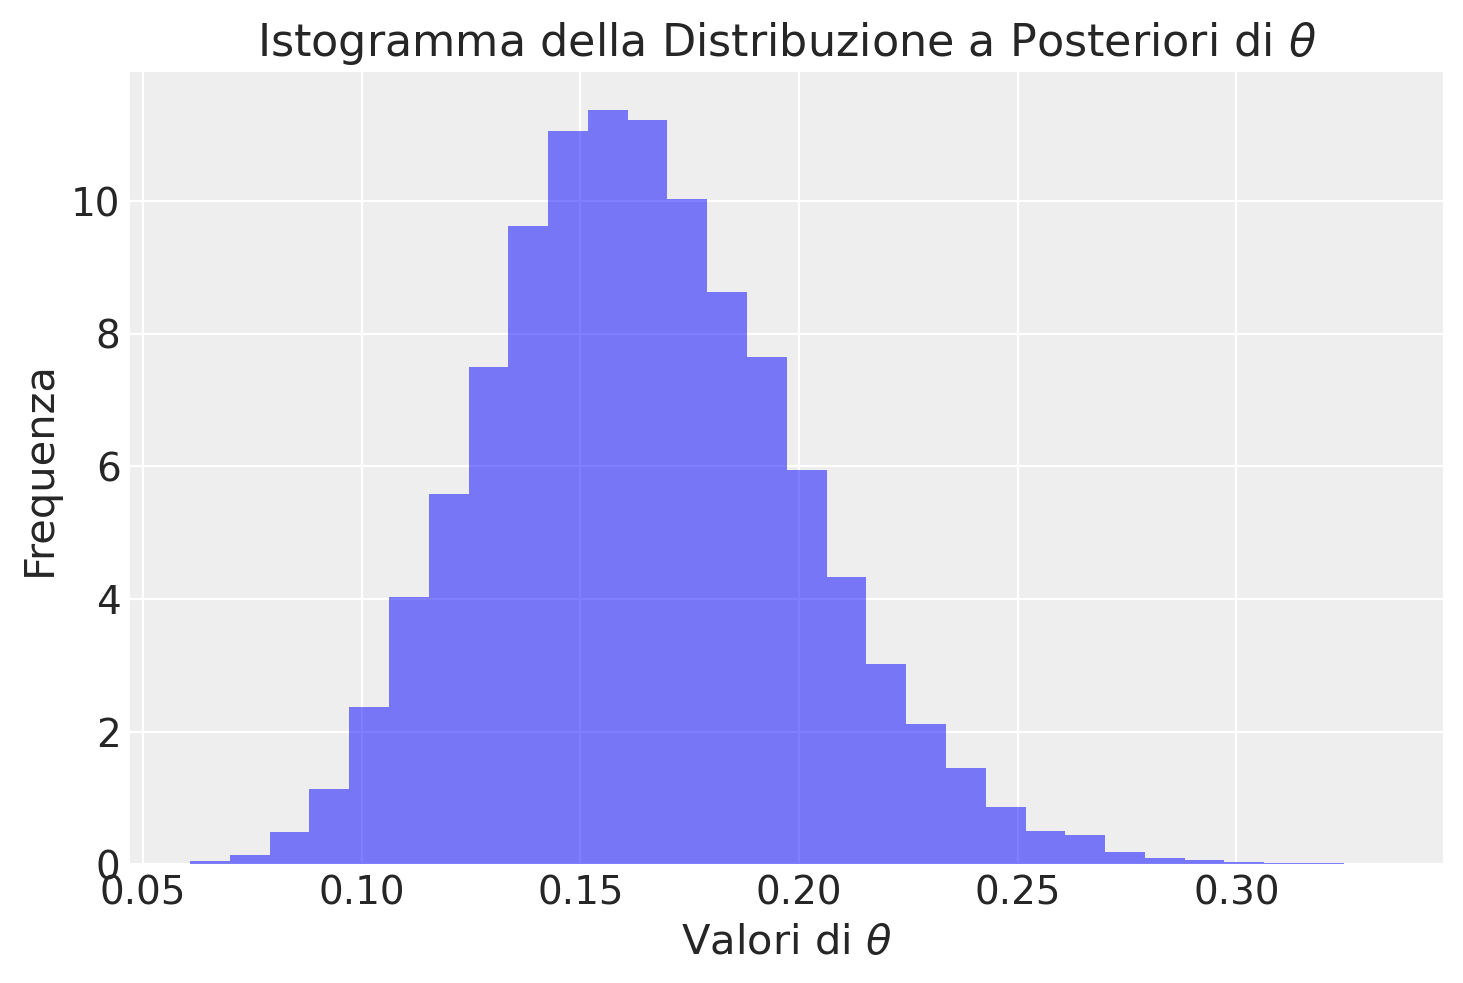

In [9]:
plt.hist(theta_samples, bins=30, density=True, alpha=0.5, color='blue')
plt.xlabel('Valori di $\\theta$')
plt.ylabel('Frequenza')
plt.title('Istogramma della Distribuzione a Posteriori di $\\theta$')
plt.show()

In alternativa, possiamo passare l'oggetto `trace` alle funzioni di ArviZ. La funzione `plot_trace` di ArviZ è particolarmente adatta a questo scopo:

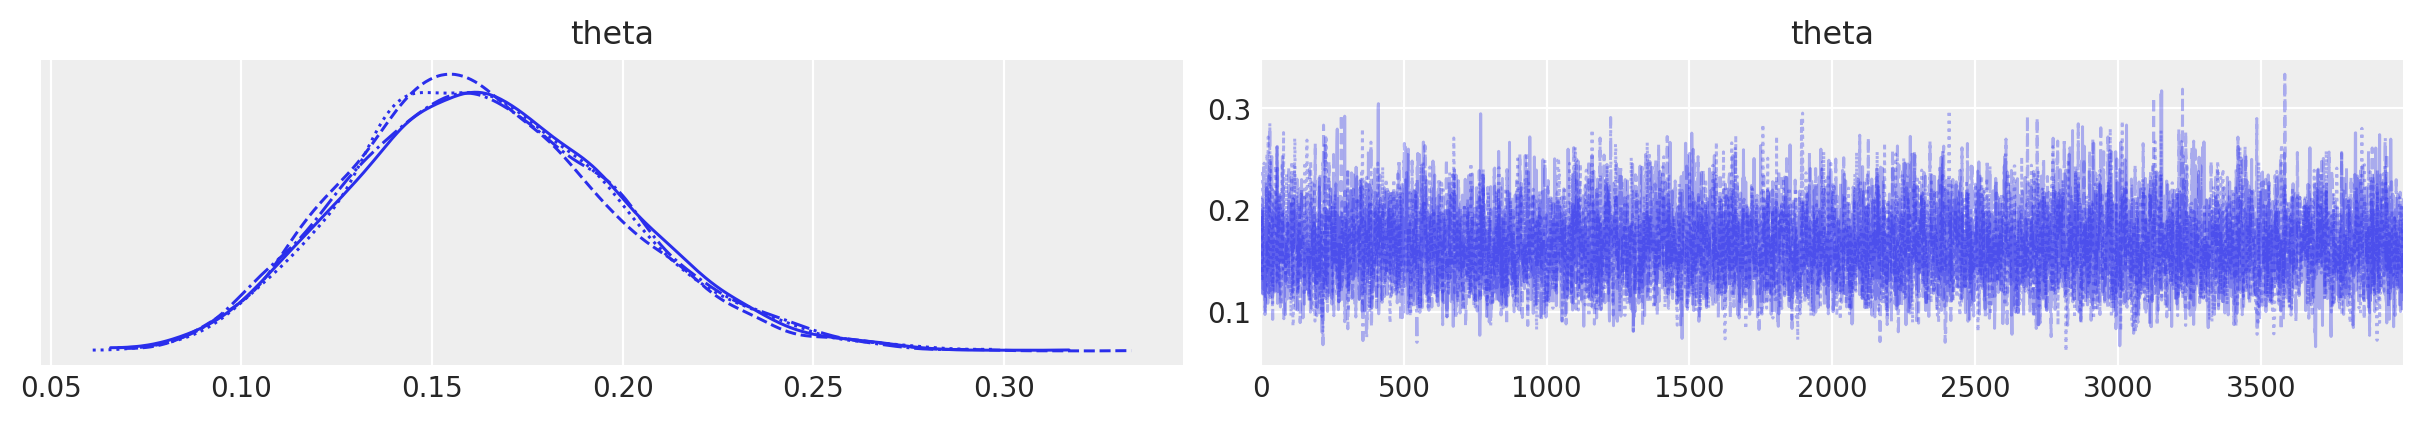

In [10]:
_ = az.plot_trace(trace, var_names=['theta'])

La figura illustra il risultato predefinito ottenuto chiamando `az.plot_trace`; vengono generati due subplot per ogni variabile non osservata. Nella configurazione del nostro modello, l'unica variabile non osservata è θ. A sinistra, viene visualizzato un grafico di stima della densità del kernel (KDE), che rappresenta una versione liscia dell'istogramma. È auspicabile che tutte le catene abbiano un KDE molto simile ad una gaussiana, come mostrato nella figura. A destra, vengono mostrati i valori individuali ad ogni passo di campionamento, con tante linee quanti sono i percorsi delle catene. L'ideale è che questa rappresentazione appaia rumorosa, senza un pattern chiaro, rendendo difficile l'identificazione di una catena rispetto alle altre. Il concetto chiave è che, eseguendo molte catene, ci aspettiamo che risultino praticamente indistinguibili l'una dall'altra. Nel caso presente, il campionatore ha svolto un buon lavoro e possiamo fiduciosi nei risultati ottenuti.

Confrontiamo la distribuzione a posteriori con la distribuzione a priori di $\theta$.

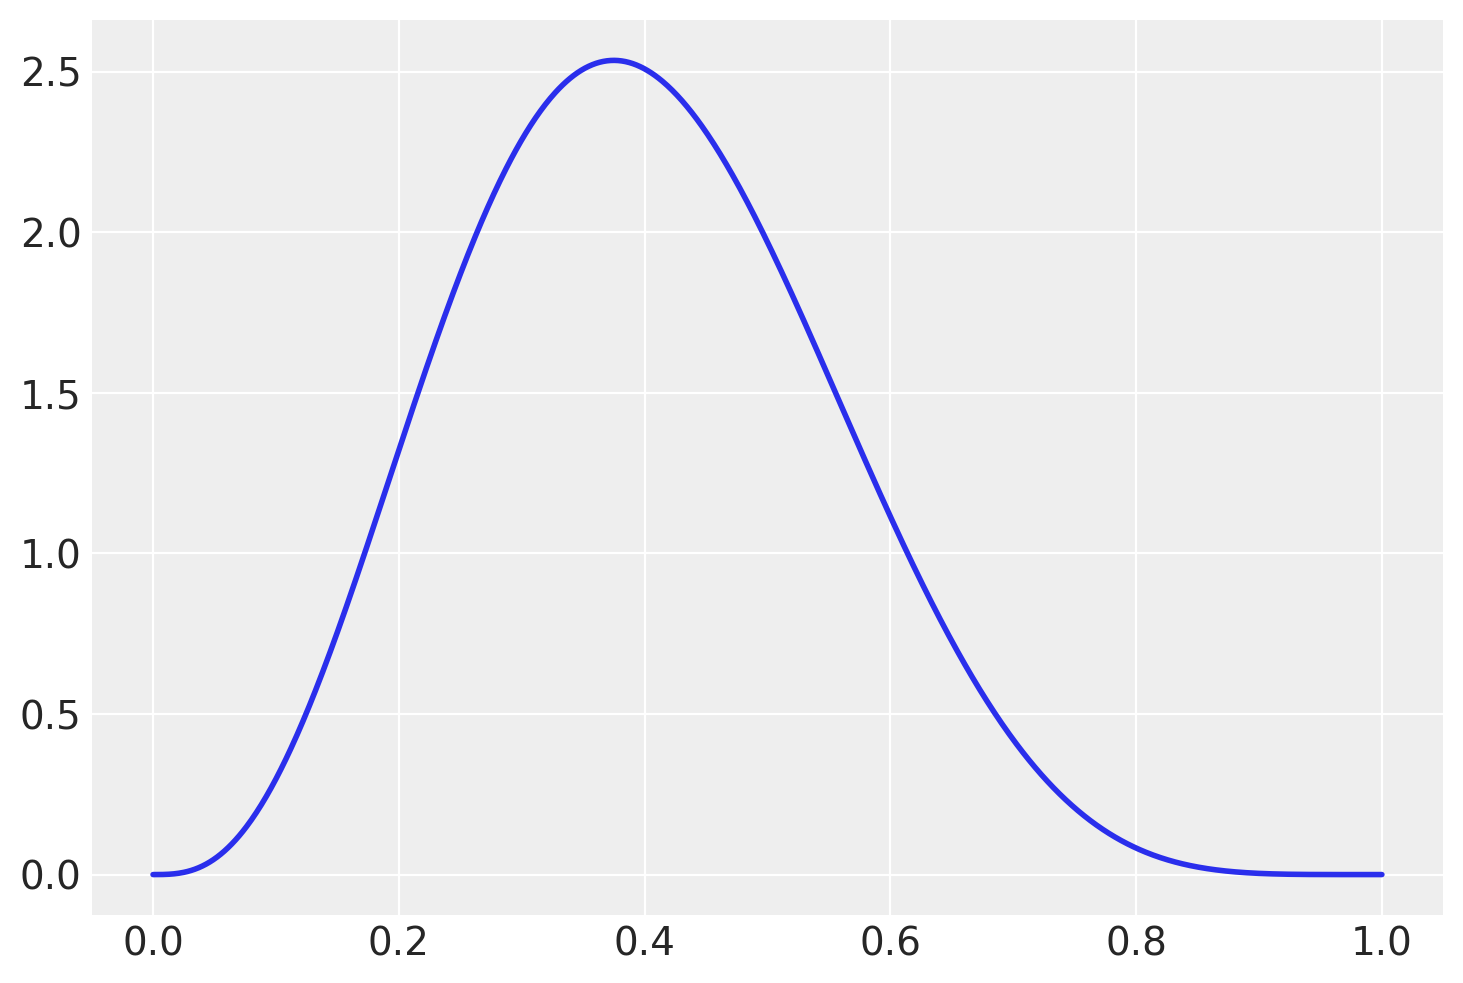

In [11]:
# Parametri della distribuzione Beta
alpha, beta_param = 4, 6

# Creazione di un range di valori
x = np.linspace(0, 1, 1000)

# Calcolo della PDF
pdf = stats.beta.pdf(x, alpha, beta_param)

# Visualizzazione della PDF
_ = plt.plot(x, pdf, lw=2)

Nel caso presente, la distribuzione a posteriori differisce in maniera importante dalla distribuzione a priori. Ciò indica che i dati hanno avuto un forte impatto sulle nostre credenze riguardo al valore del parametro.

### Intervallo di credibilità

La funzione `az.plot_posterior` ci consente di generare un grafico della distribuzione a posteriori che include la media e l'intervallo di credibilità HDI al 94%. Questo tipo di grafico è stato presentato da John K. Kruschke nel suo libro "Doing Bayesian Data Analysis" @doingbayesian.

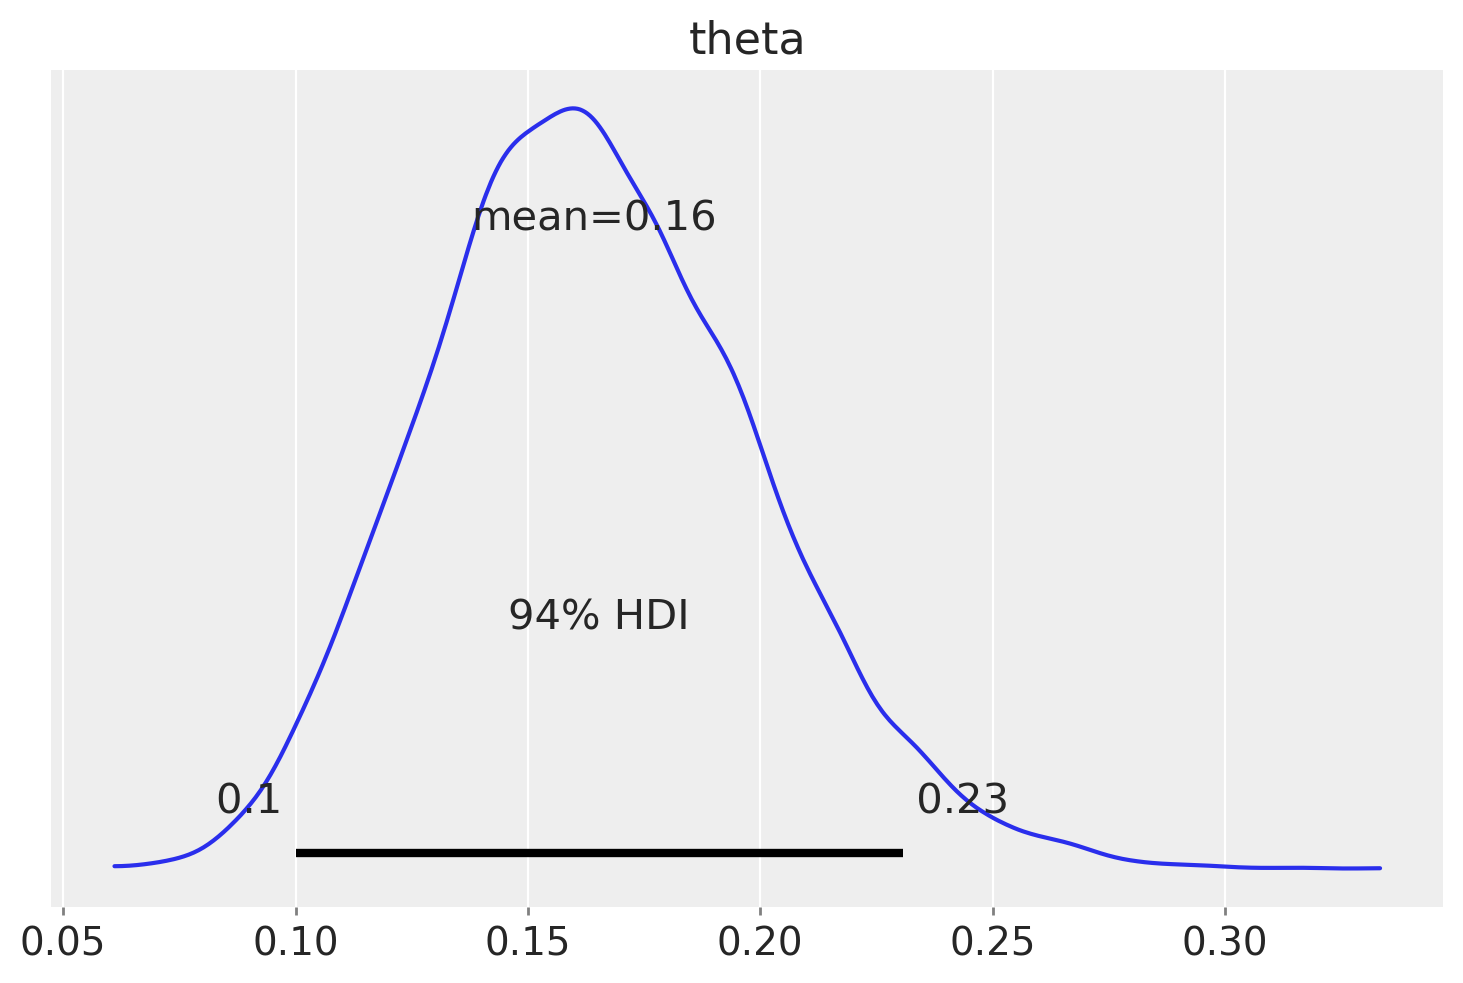

In [12]:
_ = az.plot_posterior(trace, var_names=['theta'])

L'intervallo di credibilità fornisce una stima dell'intervallo entro cui il parametro si trova con una certa probabilità. Nel caso presente, l'intervallo di credibilità del 94% ci dice che, data la nostra comprensione a posteriori del parametro, c'è il 94% di probabilità che il vero valore del parametro si trovi all'interno dell'intervallo [0.1, 0.23].

A differenza dell'intervallo di confidenza frequentista, che è interpretato in termini di lungo termine su ripetuti campionamenti, l'intervallo di credibilità bayesiano è direttamente interpretato come la probabilità che il parametro si trovi all'interno di un certo intervallo dato il set di dati specifico.

Un sommario numerico della distribuzione a posteriori si ottiene con la funzione `az.summary`, la quale ritorna una Pandas Data Frame:

In [13]:
az.summary(trace, var_names=['theta'], kind="stats").round(2)

,mean,sd,hdi_3%,hdi_97%
theta,0.16,0.04,0.1,0.23


Nella prima colonna abbiamo il nome della variabile, nella seconda colonna troviamo la media del posteriore, nella terza colonna la deviazione standard del posteriore, e nelle ultime due colonne troviamo i limiti inferiore e superiore dell'intervallo di densità più alta al 94%. Di conseguenza, secondo il nostro modello e i dati a disposizione, riteniamo che il valore di θ sia probabilmente 0.16, con una probabilità del 94% che si trovi effettivamente tra 0.1 e 0.23. Possiamo riportare un riassunto simile utilizzando la deviazione standard. Il vantaggio della deviazione standard rispetto all'HDI è che è una statistica più conosciuta. Come svantaggio, dobbiamo essere più attenti nell'interpretarla; altrimenti, potrebbe portare a risultati privi di significato. Nel caso presente, se calcoliamo la media ± 2 deviazioni standard, otterremo gli intervalli (0.08, 0.24) che sono simili ai limiti dell'intervallo HDI riportato sopra.

In [14]:
[0.16 + i*0.04 for i in (-2, 2)]

[0.08, 0.24]


Tuttavia, in alcuni casi, questa procedura potrebbe generare un limite inferiore o superiore al di fuori dell'intervallo consentito per i valori di θ, il quale è compreso tra 0 e 1.

### Test di Ipotesi Bayesiane

In alcune situazioni, la mera descrizione della distribuzione a posteriori non basta. Spesso ci troviamo di fronte alla necessità di fare scelte basate sulle nostre inferenze, traducendo stime continue in decisioni binarie: ad esempio, affermare se un individuo è sano o malato, se un intervento ha avuto successo o meno, e così via.

Prendiamo come esempio la questione se, nel Museum of Modern Art (MoMA), gli artisti appartenenti alla generazione X rappresentino il 50% dell'intero corpus. Avvalendoci di un campione casuale di 100 opere, unitamente alle nostre convinzioni pregresse (prior), abbiamo determinato un Intervallo di Massima Densità (HDI) che va da 0.1 a 0.23. La nostra ipotesi prevede che θ (la proporzione degli artisti della generazione X) sia 0.5. Confrontando questo valore con l'HDI ottenuto, osserviamo che 0.5 non rientra nell'intervallo [0.1, 0.23]. Questo risultato può essere interpretato come un'indicazione che il MoMA manifesti una preferenza per artisti nati prima del periodo 1965-1980. Tuttavia, non possiamo escludere del tutto la possibilità che la generazione X contribuisca per metà alle opere presenti nel museo. Per arrivare a una conclusione più definita, sarebbe necessario raccogliere ulteriori dati per ridurre la variabilità della distribuzione a posteriori, o considerare l'adozione di un prior più informativo per affinare la nostra analisi.

Oppure possiamo chiederci quale sia la probabilità che il valore a posteriori $\theta$ assuma un valore minore di 0.5. La funzione `az.plot_posterior(idata, ref_val=0.5)` ci dice che questa probabilità è uguale a 1. Ovvero, possiamo essere del tutto certi che la proporzione di opere d'arte della generazione X rappresentate al MoMA sia minore del 50% del totale.

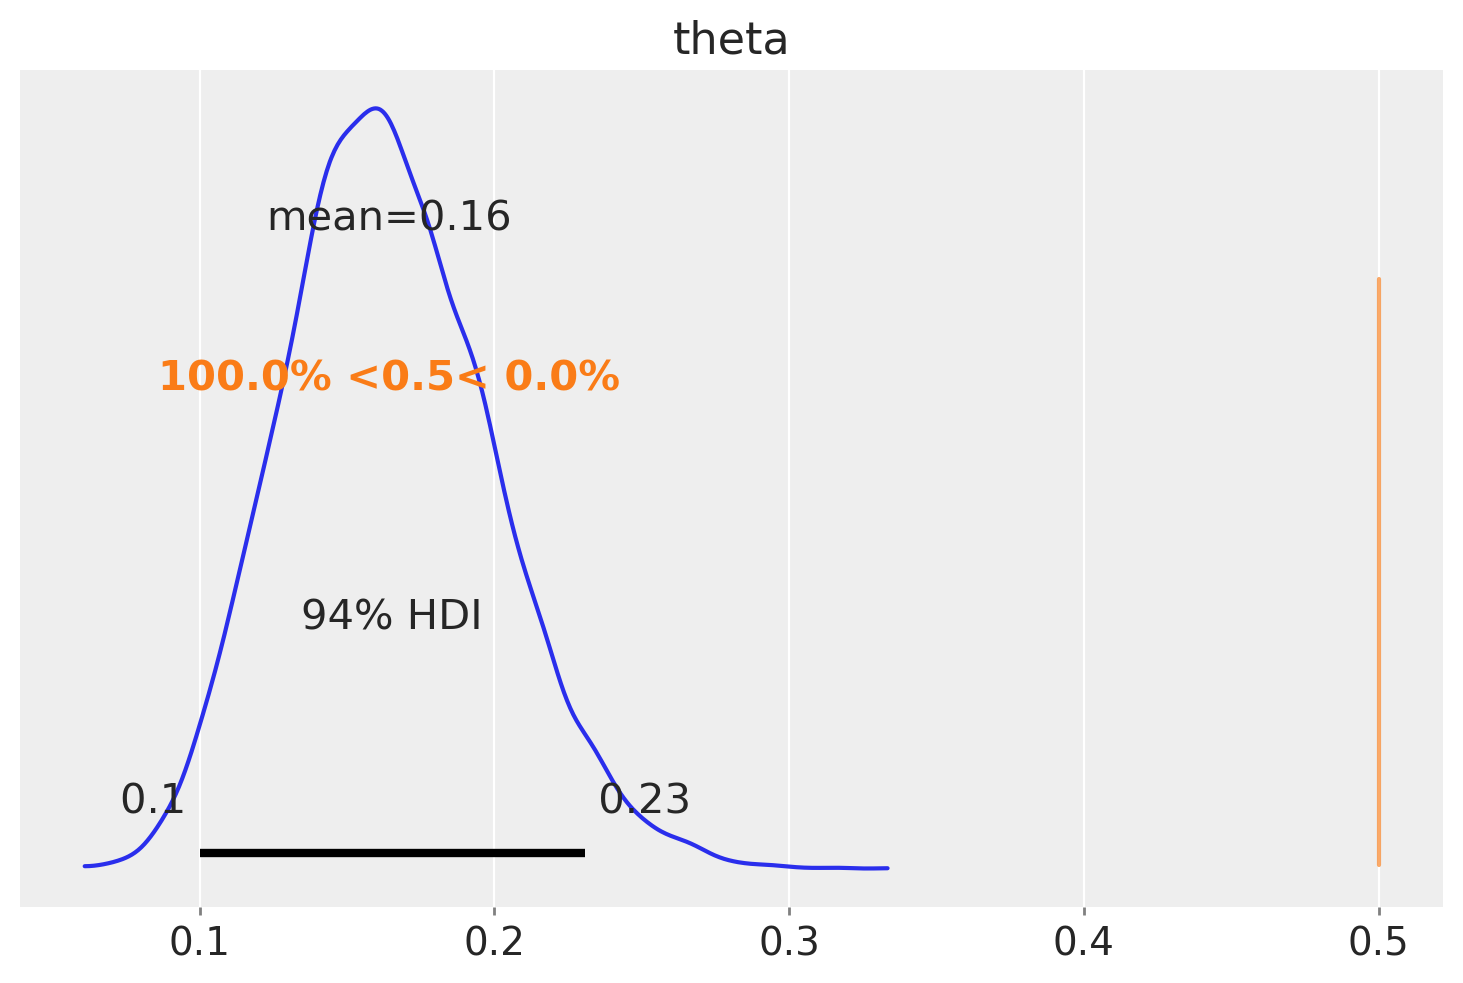

In [15]:
_ = az.plot_posterior(trace, var_names=['theta'], ref_val=0.5)

Possiamo usare qualsiasi valore di riferimento. Per esempio

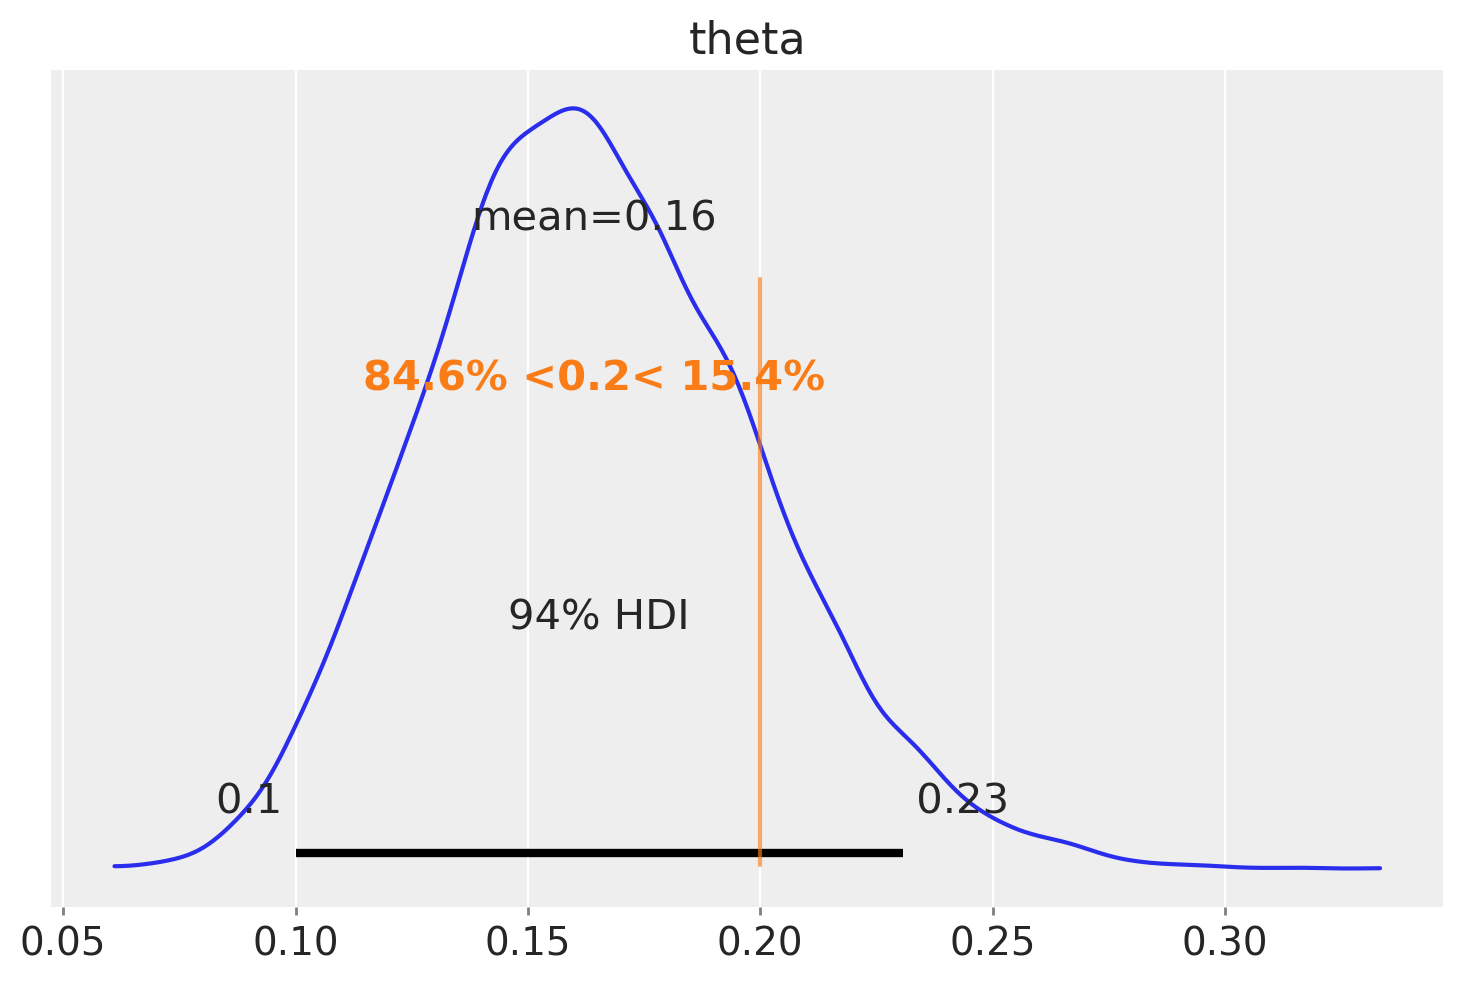

In [16]:
_ = az.plot_posterior(trace, var_names=['theta'], ref_val=0.20)

## La Regione di Equivalenza Pratica (ROPE)

La Regione di Equivalenza Pratica (ROPE) costituisce un elemento chiave nei test di equivalenza, mirando a stabilire la rilevanza pratica di un parametro. Questa regione si allinea a un'ipotesi nulla predefinita, permettendo di valutare se un parametro può essere considerato equivalente rispetto a tale ipotesi.

È fondamentale comprendere che, data l'infinita precisione teorica nella misurazione dei parametri, la probabilità di identificare un valore esatto di un parametro è sempre uguale a zero. Pertanto, l'analisi si concentra non sull'ottenimento di valori precisi, ma piuttosto su valori che rientrano in un intervallo di accettabilità prefissato.

Il metodo decisionale "HDI+ROPE" (Kruschke, 2014; Kruschke & Liddell, 2018) viene frequentemente utilizzato per determinare se i valori di un parametro debbano essere considerati accettabili o meno in relazione all'ipotesi nulla delineata dalla ROPE. Questo metodo esamina la percentuale dell'Intervallo Credibile (CI) che si trova all'interno della ROPE, considerata come regione corrispondente all'ipotesi nulla. Se questa percentuale è notevolmente bassa, l'ipotesi nulla viene scartata; viceversa, se è elevata, l'ipotesi viene accettata.

Per illustrare, consideriamo l'esempio di una moneta teoricamente equilibrata, la cui probabilità di ottenere "testa" si vuole sia vicina al valore teorico di 0.5. Al posto di focalizzarsi esclusivamente sul valore esatto di 0.5, possiamo definire una ROPE, ad esempio tra [0.45, 0.55]. Tale intervallo viene considerato praticamente equivalente a 0.5 ai fini della nostra analisi, consentendo di valutare l'equità della moneta tenendo conto delle naturali fluttuazioni nelle misurazioni.

Dopo aver definito la ROPE, confrontiamo il nostro risultato con l'intervallo di densità più alta (HDI). Da questo confronto emergono tre possibili scenari:

1. **Assenza di sovrapposizione tra ROPE e HDI**: Indica che i risultati ottenuti sono sufficientemente distanti dall'intervallo di equivalenza pratica, portando al rifiuto dell'ipotesi di equivalenza. Questo scenario suggerisce che il parametro analizzato ha un impatto pratico che va oltre l'ipotesi di nullità considerata dalla ROPE.

2. **La ROPE include completamente l'HDI**: Questo scenario si verifica quando l'intero intervallo di densità più alta cade all'interno della ROPE, indicando che i risultati sono pienamente compatibili con l'ipotesi di nullità. In questo caso, possiamo accettare l'ipotesi che il parametro sia praticamente equivalente all'ipotesi nulla, suggerendo una mancanza di significatività pratica del parametro in esame.

3. **Sovrapposizione parziale tra ROPE e HDI**: In questo caso, una porzione dell'HDI si sovrappone con la ROPE, ma non completamente. Questo risultato implica che non possiamo trarre conclusioni definitive riguardo all'equivalenza pratica del parametro rispetto all'ipotesi nulla. Si rende necessaria un'ulteriore analisi o l'impiego di altri criteri decisionali per determinare la rilevanza pratica del parametro.

Considerando un esempio relativo all'analisi dei dati della Generazione X, con una ROPE definita come [0.25, 0.35]. 

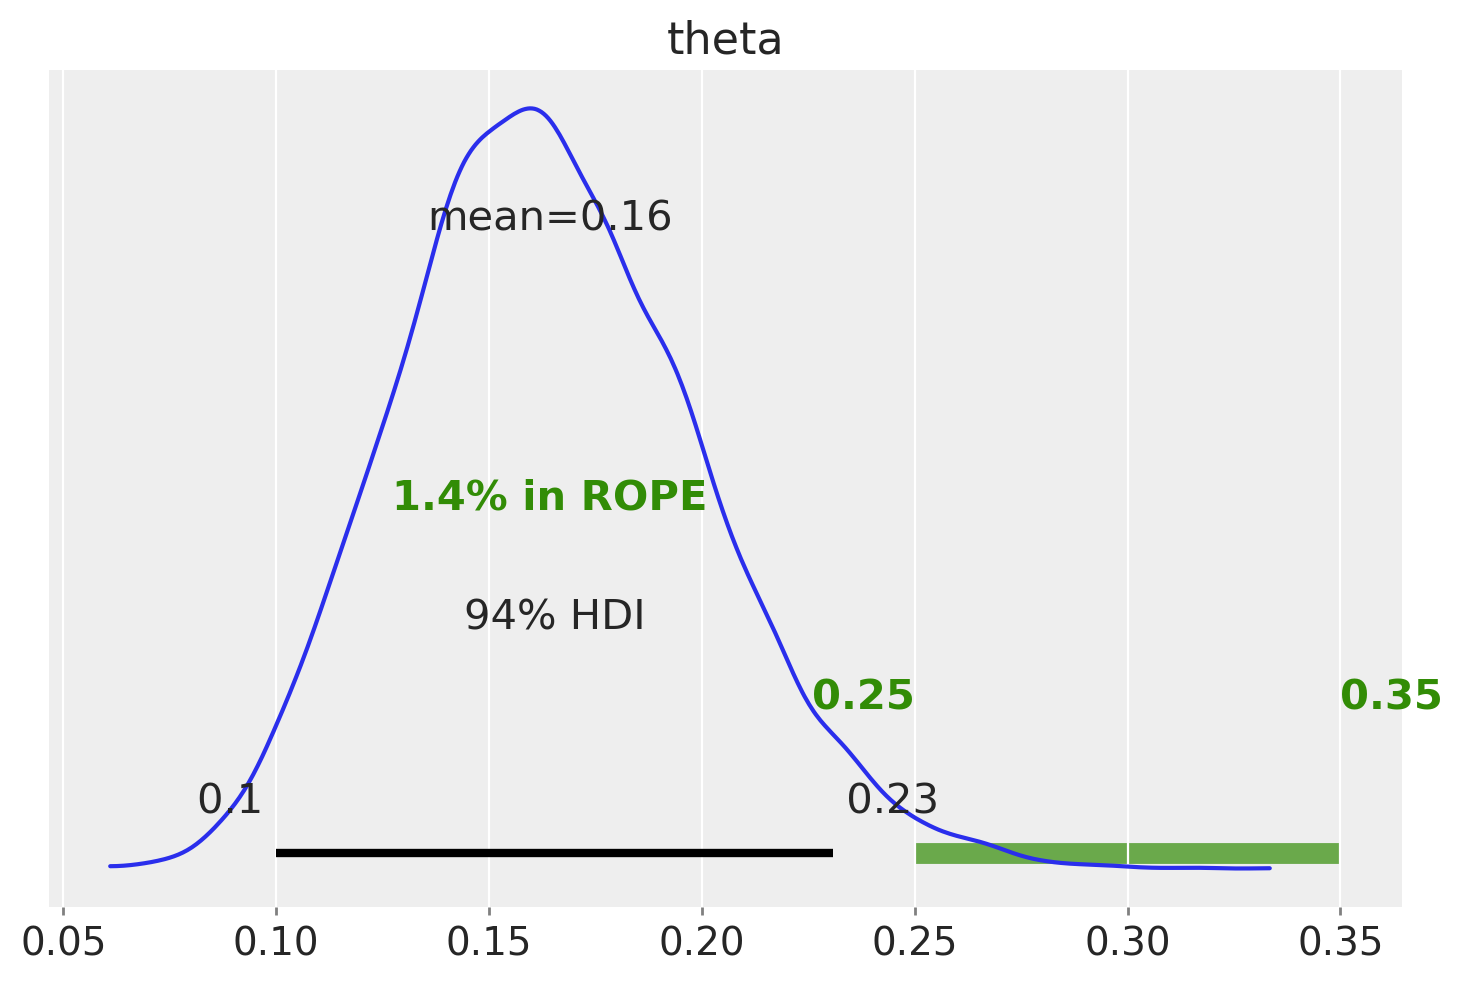

In [17]:
_ = az.plot_posterior(trace, var_names=['theta'], rope=[0.25, .35])

La ROPE così definita corrisponde all'ipotesi del parametro $\theta$ = 0.3 e considerando equivalenti i valori osservati nell'intervallo [0.25, 0.35]. 

L'analisi mostra che l'HDI non si sovrappone alla ROPE. Inoltre, solo l'1.3% della distribuzione a posteriori è contenuta nella ROPE. Possiamo dunque rifiutare l'ipotesi specificata dalla ROPE.

## Estrazione degli attributi da `InferenceData`

Vediamo ora nei dettagli come sia possibile effettuare le varie operazioni sulla distribuzione a posteriori, ovvero la stima puntuale, gli intervalli di credibilità e i test di ipotesi, mediante la manipolazione dell'oggetto `theta_draws` ottenuto dalla funzione `sample.stan_variable()`.

## Stima puntuale

Possiamo recuperare la traccia di campionamento dalla variabile latente `theta` nel modo seguente:

In [18]:
theta_draws = trace.stan_variable('theta')
theta_draws.shape

(16000,)

In cmdstanpy, quando si utilizza il metodo `stan_variable` per estrarre i campioni di un parametro specifico dai campioni posteriori, questo restituisce un array numpy contenente i campioni.

Il metodo `stan_variable('theta')` estrae tutti i campioni per il parametro `theta` dalla distribuzione posteriore. Questo include i campioni da tutte le catene e tutte le iterazioni dopo il warmup. Il risultato, `theta_draws`, è un array numpy in cui i campioni di tutte le catene sono concatenati insieme. La forma di `theta_draws` è tipicamente `(num_samples * num_chains, )` se `theta` è un parametro scalare, o `(num_samples * num_chains, dim1, dim2, ...)` se `theta` è un vettore o una matrice. I campioni delle 4 catene sono concatenati. Questo significa che i campioni di ciascuna catena sono aggiunti uno dopo l'altro in un singolo array. Non sono mescolati insieme in modo casuale; piuttosto, sono semplicemente posizionati in sequenza.

Per visualizzare il primi 30 valori di `theta_draws`, ad esempio, usiamo:

In [45]:
theta_draws[0:30]

array([0.152399, 0.164544, 0.185841, 0.210788, 0.210788, 0.158488,
       0.152418, 0.117835, 0.161514, 0.168753, 0.137032, 0.162867,
       0.168521, 0.182565, 0.123249, 0.114717, 0.123867, 0.128263,
       0.171871, 0.142336, 0.204677, 0.221803, 0.171478, 0.121296,
       0.108108, 0.199047, 0.133709, 0.138647, 0.144356, 0.174385])

Di conseguenza, possiamo calcolare su `theta_draws` tutte le misure statistiche descrittive che si possono ottenere da un vettore di dati. Per esempio, possiamo calcolare la media a posteriori.

In [46]:
np.mean(theta_draws)

0.16424613186875

Possiamo calcolare la mediana a posteriori di $\theta$.

In [47]:
np.median(theta_draws)

0.16208250000000002

Oppure la deviazione standard della stima a posteriori di $\theta$.

In [48]:
np.std(theta_draws)

0.03521655992174475

## Intervallo di credibilità

L'inferenza bayesiana tramite l'intervallo di credibilità riguarda invece la stima dell'intervallo che contiene il parametro $\theta$ ad un dato livello di probabilità soggettiva. 

Usando l'oggetto `sample`, possiamo ottenere un sommario della distribuzione a posteriori con il metodo `az.summary()`.

In [49]:
az.summary(trace, var_names=['theta'], hdi_prob=0.94, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.164,0.035,0.1,0.231,0.0,0.0,5412.045,7678.797,1.0


Si ottiene così l'intervallo di credibilità a più alta densità a posteriori (HPD) al 94%. Questo intervallo ci informa sul fatto che, a posteriori, possiamo essere certi al 94%, che il vero valore del parametro $\theta$ sia contenuto nell'intervallo [0.103, 0.23].

Dato che, nel caso presente, conosciamo la soluziona analitica, possiamo verificare il risultato precedente calcolando i quantili della distribuzione a posteriori Beta(18, 92) di ordine 0.03 e 0.97.

In [50]:
ll = stats.beta.ppf(0.03, 18, 92)
ul = stats.beta.ppf(0.97, 18, 92)
list([ll, ul])

[0.10303527075398665, 0.23457657606771784]

## Verifica di ipotesi bayesiana

Un secondo tipo di inferenza bayesiana riguarda problemi in cui siamo interessati a valutare la plausibilità che il parametro $\theta$ assuma valori contenuti in un dato intervallo di valori. Per esempio, ci potrebbe interessare l'ipotesi $\theta > 0.5$. In questo caso, possiamo calcolare la probabilità a posteriori che $\theta$ cada nell'intervallo di interesse, integrando la distribuzione a posteriori Beta su tale intervallo.

Nel caso dell'esempio degli artisti della Generazione X, supponiamo di essere interessati alle due seguenti ipotesi:

$$
\begin{split}
H_0: & \; \; \pi \ge 0.2 \\
H_a: & \; \; \pi < 0.2
\end{split}
$$

La nostra domanda è la seguente: Date le nostre credenze iniziali e i dati disponibili, quale importanza relativa possiamo attribuire a queste due ipotesi?

Per affrontare questa questione, iniziamo a calcolare la probabilità $P(\theta < 0.2)$.

In [51]:
print(np.mean(theta_draws < 0.2))

0.846125


Passiamo ora a calcolare gli odds a posteriori:

In [52]:
post_odds = (np.mean(theta_draws < 0.2)) / (1 - np.mean(theta_draws < 0.2))
print(post_odds)

5.498781478472787


Ciò implica che la probabilità che $\pi$ sia inferiore al 20% è circa 6 volte superiore rispetto alla probabilità che sia al di sopra del 20%.

Questo risultato si basa solo sulle informazioni relative alla distribuzione a posteriori. Prima di avere osservato i dati del campione, avevamo una distribuzione a priori $\operatorname{Beta}(6, 4)$, e in quel contesto avevamo una probabilità del 9% che $H_a$ fosse vera e una probabilità del 91% che fosse falsa.

In [53]:
threshold = 0.2
prior_prob = stats.beta.cdf(threshold, a=4, b=6)

In [54]:
prior_odds = prior_prob / (1 - prior_prob)
print(prior_odds)

0.09366320688790145


Ora possiamo combinare le informazioni degli odds a posteriori e degli odds a priori in una quantità chiamata *Bayes Factor*, che è semplicemente il rapporto tra le due:

In [55]:
BF = post_odds / prior_odds
print(BF)

58.70802058970575


In conclusione, dopo aver appreso informazioni riguardo a 14 artisti appartenenti alla generazione X, le probabilità posteriori della nostra ipotesi $H_a: \; \pi < 0.2$ sono circa 60 volte superiori rispetto alle probabilità a priori.

Questo è un esempio di test di ipotesi bayesiano.

## Commenti e considerazioni finali 

La crescente popolarità dei metodi bayesiani in psicologia e nelle scienze sociali è stata fortemente influenzata dalla (ri)scoperta di algoritmi numerici capaci di stimare le distribuzioni a posteriori dei parametri del modello a partire dai dati osservati. Prima di questi sviluppi, ottenere misure riassuntive delle distribuzioni a posteriori, soprattutto per modelli complessi con molti parametri, era praticamente impossibile.

Questo capitolo fornisce un'introduzione a `cmdstanpy`, un'implementazione in Python di `cmdstan`, che permette di compilare ed eseguire modelli probabilistici espressi in linguaggio Stan. Grazie a questa tecnologia, è possibile generare una stima della distribuzione a posteriori attraverso il campionamento Markov Chain Monte Carlo (MCMC), rivoluzionando la capacità di effettuare inferenze bayesiane e rendendo l'analisi di modelli complessi più accessibile e gestibile.

Inoltre, nel capitolo sono state presentate diverse strategie per la trasformazione della distribuzione a posteriori e sono state esplorate modalità per ottenere intervalli di credibilità. Successivamente, è stata discussa l'analisi delle ipotesi a posteriori, che consente di confrontare due ipotesi contrapposte riguardanti il parametro $\theta$. In alcune situazioni, questo confronto viene tradotto in una misura denominata Fattore di Bayes.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [42]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Mon Jun 10 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

scipy     : 1.13.1
pandas    : 2.2.2
numpy     : 1.26.4
logging   : 0.5.1.2
matplotlib: 3.8.4
cmdstanpy : 1.2.3
arviz     : 0.18.0

Watermark: 2.4.3



In [43]:
# Stampa la versione di CmdStan
print("CmdStan version:", cmdstanpy.utils.cmdstan_version())

CmdStan version: (2, 35)
